In [1]:
#Importation des librairies
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import pandas as pd
import missingno as msno
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import folium
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from yellowbrick.regressor import ResidualsPlot, prediction_error
from kmodes.kprototypes import KPrototypes

from time import time

pd.set_option("display.max_columns", None)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#On modifie les options pour rendre l'affichage des float plus lisible
pd.set_option('float_format', '{:f}'.format)

## Import des datasets

In [3]:
data = pd.read_csv("data.csv", sep=',', index_col=[0])
df = pd.read_csv("df.csv", sep=',', index_col=[0])
data_review = pd.read_csv("data_review.csv", sep=',', index_col=[0])

In [4]:
df

,order_id,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time
0,e481f51cbdc54678b7cc49136f2d6af7,1.000000,credit_card,1.000000,18.120000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574
1,e481f51cbdc54678b7cc49136f2d6af7,3.000000,voucher,1.000000,2.000000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574
2,e481f51cbdc54678b7cc49136f2d6af7,2.000000,voucher,1.000000,18.590000,a54f0611adc9ed256b57ede6b6eb5114,4.000000,2017-10-11 00:00:00,2017-10-12 03:43:48,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,sao paulo,-23.574809,-46.587471,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574
3,53cdb2fc8bc7dce0b6741e2150273451,1.000000,boleto,1.000000,141.460000,8d5266042046a06655c8db133d120ba5,4.000000,2018-08-08 00:00:00,2018-08-08 18:37:50,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,barreiras,-12.169860,-44.988369,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,13.782037
4,47770eb9100c2d0c44946d9cf07ec65d,1.000000,credit_card,3.000000,179.120000,e73b67b67587f7644d5bd1a52deb1b01,5.000000,2018-08-18 00:00:00,2018-08-22 19:07:58,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,-16.746337,-48.514624,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,9.394213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104473,9c5dedf39a927c1b2549525ed64a053c,1.000000,credit_card,3.000000,85.080000,e262b3f92d1ce917aa412a9406cf61a6,5.000000,2017-03-22 00:00:00,2017-03-23 11:02:08,39bd1228ee8140590ac3aca26f2dfe00,6359f309b166b0196dbf7ad2ac62bb5a,sao jose dos campos,-23.172205,-45.880056,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00,8.218009
104474,63943bddc261676b46f01ca7ac2f7bd8,1.000000,credit_card,3.000000,195.000000,29bb71b2760d0f876dfa178a76bc4734,4.000000,2018-03-01 00:00:00,2018-03-02 17:50:01,1fca14ff2861355f6e5f14306ff977a7,da62f9e57a76d978d02ab5362c509660,praia grande,-24.001467,-46.446355,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,22.193727
104475,83c1379a015df1e13d02aae0204711ab,1.000000,credit_card,5.000000,271.010000,371579771219f6db2d830d50805977bb,5.000000,2017-09-22 00:00:00,2017-09-22 23:10:57,1aa71eb042121263aafbe80c1b562c9c,737520a9aad80b3fbbdad19b66b37b30,nova vicosa,-17.891522,-39.370942,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,24.859421
104476,11c177c8e97725db2631073c19f07b62,1.000000,credit_card,4.000000,441.160000,8ab6855b9fe9b812cd03a480a25058a1,2.000000,2018-01-26 00:00:00,2018-01-27 09:16:56,b331b74b18dc79bcdf6532d51e1637c1,5097a5312c8b157bb7be58ae360ef43c,japuiba,-22.555985,-42.690761,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,17.086424


In [5]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10, 10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data_pca = data[["Récence", "Fréquence", "Montant"]]

X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

In [7]:
data_pca["Fréquence"].describe()

count   96095.000000
mean        0.032645
std         0.177706
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Fréquence, dtype: float64

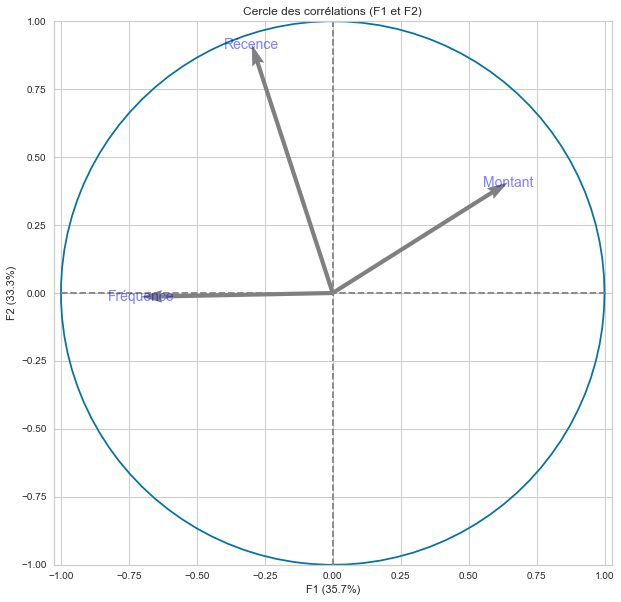

In [8]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

In [9]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.style import set_palette

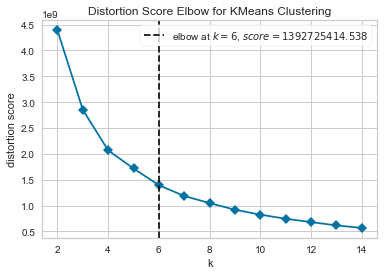

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 15), metric='distortion', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [11]:
'''
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
#Kmeans Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    visualizer = SilhouetteVisualizer(clusterer,colors='yellowbrick')
    #Fit the data to the visualizer
    visualizer.fit(X)
    #Render the figure
    visualizer.show()
    '''

'\nfrom sklearn.metrics import silhouette_score\nfrom yellowbrick.cluster import SilhouetteVisualizer\n#Kmeans Clustering\nrange_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]\nfor n_clusters in range_n_clusters:\n    #Initializing the clusterer with n_clusters value and a random   generator\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10)\n    cluster_labels = clusterer.fit_predict(X)\n    #The silhouette_score gives the average value for all the   samples.\n    #Calculating number of clusters\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)\n    #Using Silhouette Plot\n    visualizer = SilhouetteVisualizer(clusterer,colors=\'yellowbrick\')\n    #Fit the data to the visualizer\n    visualizer.fit(X)\n    #Render the figure\n    visualizer.show()\n    '

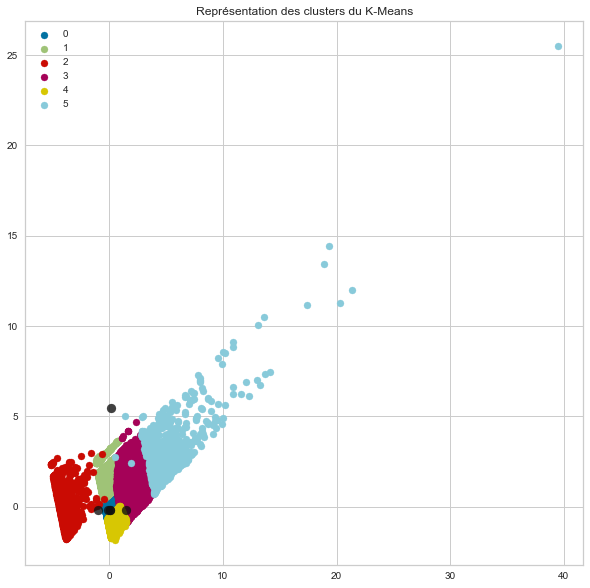

In [12]:
km = KMeans(n_clusters=6)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [13]:
data["clusters"] = km.labels_
for i in range(0, len(data['clusters'].unique())):
    print("Nombre de clients dans le cluster n°", i, " : ", data['customer_unique_id'].loc[data['clusters'] == i].count())

Nombre de clients dans le cluster n° 0  :  33236
Nombre de clients dans le cluster n° 1  :  21029
Nombre de clients dans le cluster n° 2  :  3134
Nombre de clients dans le cluster n° 3  :  4539
Nombre de clients dans le cluster n° 4  :  33520
Nombre de clients dans le cluster n° 5  :  637


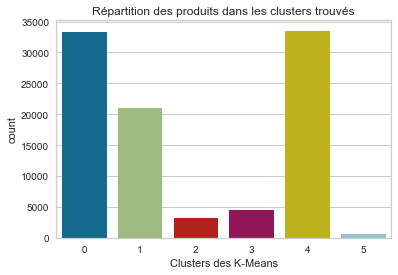

In [14]:
sns.countplot(x="clusters", data=data)
plt.xlabel("Clusters des K-Means")
plt.title("Répartition des produits dans les clusters trouvés")
plt.show()

In [15]:
clusters_stats = data.groupby("clusters").mean()
clusters_stats

,Récence,Fréquence,Montant,r_quartile,f_bins,m_quartile,RFM_Score
clusters,,,,,,,
0,305.308370,0.000000,118.615943,2.709622,2.000000,2.587465,293.549675
1,509.917875,0.000000,125.621603,4.000000,2.000000,2.555947,422.555947
2,314.047543,1.000000,79.780793,2.668156,1.997766,3.324505,290.117741
3,276.765807,0.000000,665.163825,2.421238,2.000000,1.000000,263.123816
4,136.621569,0.000000,124.129630,1.336456,2.000000,2.533144,156.178729
5,294.489796,0.004710,1931.147331,2.492936,2.000000,1.000000,270.293564


In [16]:
data_review["Fréquence"] = np.where(data_review["Fréquence"] > 1, 1, 0)

In [17]:
data_review

,customer_unique_id,Récence,Fréquence,Montant,Avis,Delivery_time
0,0000366f3b9a7992bf8c76cfdf3221e2,160,0,141.900000,5.000000,6.411227
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,0,27.190000,4.000000,3.285590
2,0000f46a3911fa3c0805444483337064,585,0,86.220000,3.000000,25.731759
3,0000f6ccb0745a6a4b88665a16c9f078,369,0,43.620000,4.000000,20.037083
4,0004aac84e0df4da2b147fca70cf8255,336,0,196.890000,5.000000,13.141134
...,...,...,...,...,...,...
96090,fffcf5a5ff07b0908bd4e2dbc735a684,495,0,2067.420000,5.000000,27.514861
96091,fffea47cd6d3cc0a88bd621562a9d061,310,0,84.580000,4.000000,30.097500
96092,ffff371b4d645b6ecea244b27531430a,617,0,112.460000,5.000000,14.872083
96093,ffff5962728ec6157033ef9805bacc48,168,0,133.690000,5.000000,11.858854


In [18]:
data_review.dropna(subset=["Avis"], inplace=True)
data_review["Avis"].isnull().sum().sum()

0

In [19]:
data_review["Delivery_time"].describe()

count   92637.000000
mean       12.528078
std         9.497348
min         0.533414
25%         6.759514
50%        10.203588
75%        15.694664
max       208.351759
Name: Delivery_time, dtype: float64

In [20]:
data_review["Delivery_time"].isnull().sum()

2717

In [21]:
data_review = data_review[data_review['Delivery_time'].notna()]
data_review["Delivery_time"].isnull().sum()

0

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data_pca = data_review[["Récence", "Fréquence", "Montant", "Avis", "Delivery_time"]]

X = data_pca.values
features = data_pca.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

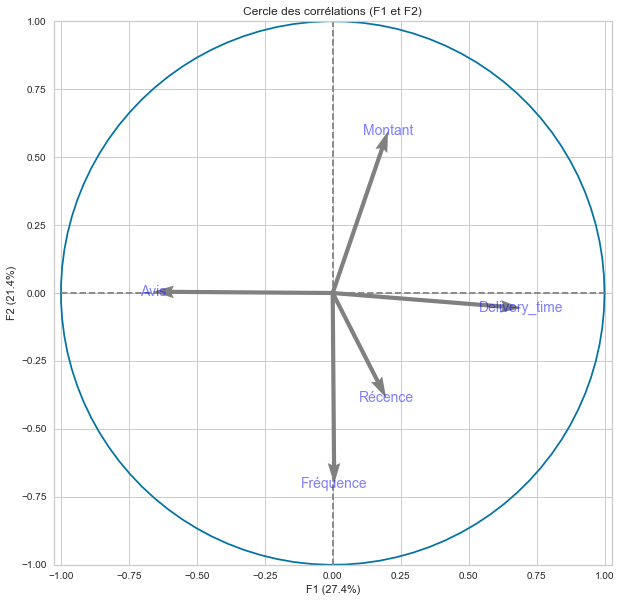

In [23]:
display_circles(pcs, n_comp, pca, [(0, 1)], labels=np.array(features))

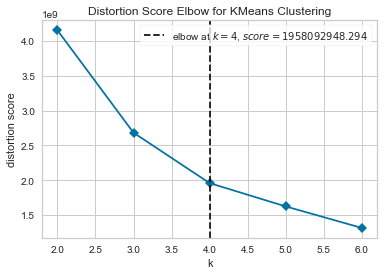

In [24]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2, 7), metric='distortion', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [25]:
'''
#Kmeans Clustering
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters:
    #Initializing the clusterer with n_clusters value and a random   generator
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    #The silhouette_score gives the average value for all the   samples.
    #Calculating number of clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)
    #Using Silhouette Plot
    visualizer = SilhouetteVisualizer(clusterer,colors='yellowbrick')
    #Fit the data to the visualizer
    visualizer.fit(X)
    #Render the figure
    visualizer.show()
    '''

'\n#Kmeans Clustering\nrange_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]\nfor n_clusters in range_n_clusters:\n    #Initializing the clusterer with n_clusters value and a random   generator\n    clusterer = KMeans(n_clusters=n_clusters, random_state=10)\n    cluster_labels = clusterer.fit_predict(X)\n    #The silhouette_score gives the average value for all the   samples.\n    #Calculating number of clusters\n    silhouette_avg = silhouette_score(X, cluster_labels)\n    print("For n_clusters =", n_clusters,"The average   silhoutte_score is :", silhouette_avg)\n    #Using Silhouette Plot\n    visualizer = SilhouetteVisualizer(clusterer,colors=\'yellowbrick\')\n    #Fit the data to the visualizer\n    visualizer.fit(X)\n    #Render the figure\n    visualizer.show()\n    '

### Stabilité du clustering inter-seed

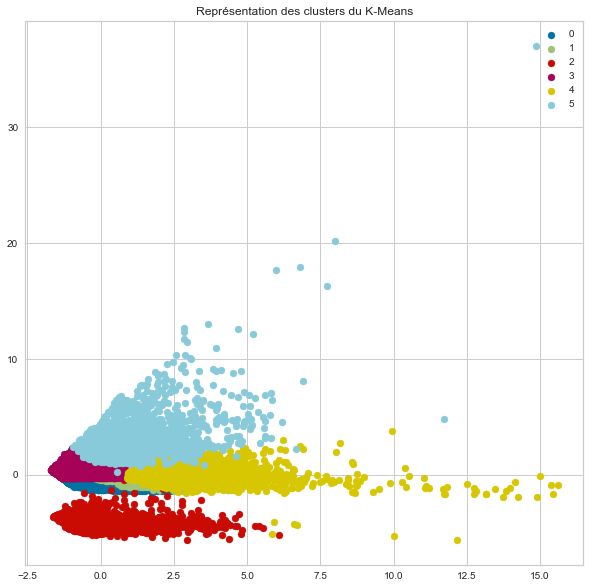

In [26]:
km = KMeans(n_clusters=6, random_state=1)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels_1 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_1:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

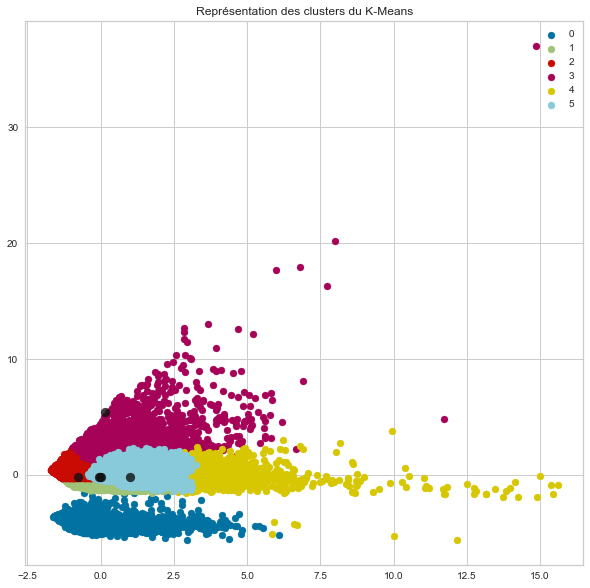

In [27]:
km = KMeans(n_clusters=6, random_state=2)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels_2 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_2:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, alpha=0.8, color='k')

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

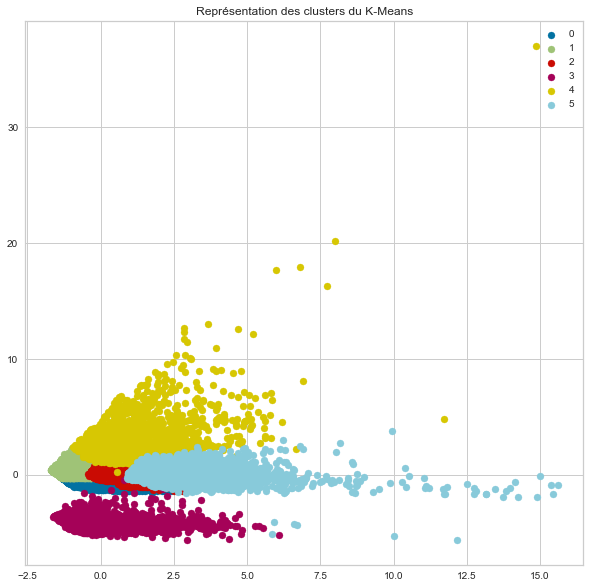

In [28]:
km = KMeans(n_clusters=6, random_state=3)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels_3 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_3:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

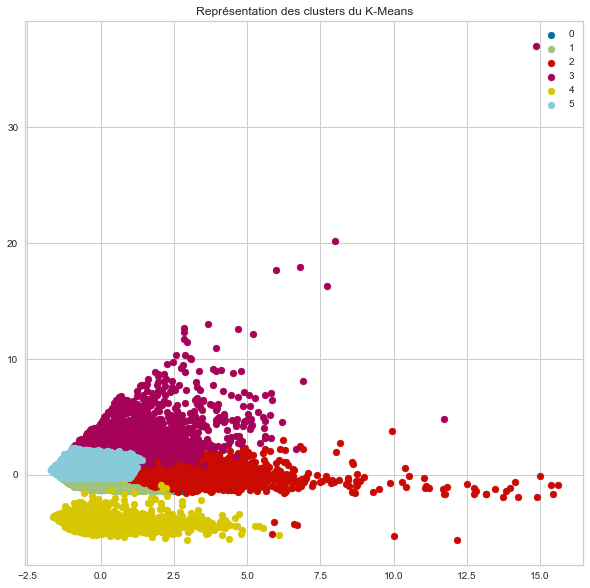

In [29]:
km = KMeans(n_clusters=6, random_state=4)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels_4 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_4:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)

plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

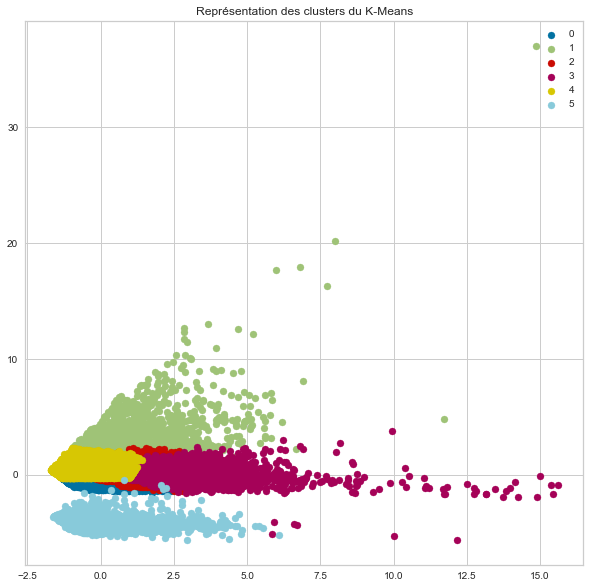

In [30]:
km = KMeans(n_clusters=6, random_state=5)
label = km.fit_predict(X_scaled)
centroids = km.cluster_centers_
u_labels_5 = np.unique(label)
plt.figure(figsize=(10, 10))

for i in u_labels_5:
    plt.scatter(pca_components[label == i, 0], pca_components[label == i, 1], label=i)
    
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [31]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [32]:
ari=[]
seed=[2,3,4,5]
ari.append(adjusted_rand_score(u_labels_1, u_labels_2))
ari.append(adjusted_rand_score(u_labels_2, u_labels_3))
ari.append(adjusted_rand_score(u_labels_3, u_labels_4))
ari.append(adjusted_rand_score(u_labels_4, u_labels_5))

df_ari = pd.DataFrame({'ari': ari, 'seed': seed})

<AxesSubplot:xlabel='seed', ylabel='ari'>

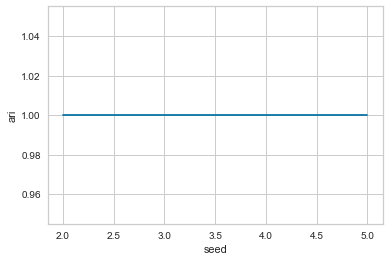

In [33]:
sns.lineplot(data=df_ari, x="seed", y="ari")

In [34]:
data_review["clusters"] = km.labels_
for i in range(0, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° 0  :  30922
Nombre d'individus dans le cluster n° 1  :  2043
Nombre d'individus dans le cluster n° 2  :  11750
Nombre d'individus dans le cluster n° 3  :  5003
Nombre d'individus dans le cluster n° 4  :  39905
Nombre d'individus dans le cluster n° 5  :  3014


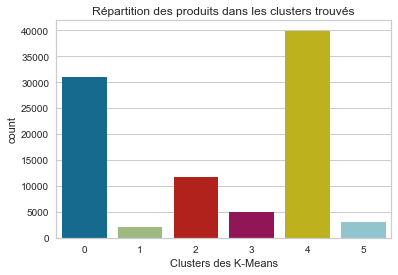

In [35]:
sns.countplot(x="clusters", data=data_review)
plt.xlabel("Clusters des K-Means")
plt.title("Répartition des produits dans les clusters trouvés")
plt.show()

In [36]:
clusters_stats = data_review.groupby("clusters").mean()
clusters_stats

,Récence,Fréquence,Montant,Avis,Delivery_time
clusters,,,,,
0,440.433057,0.000000,132.621624,4.654291,11.588352
1,285.731278,0.001468,1200.684787,4.141948,13.500582
2,277.281787,0.000000,146.253257,1.845191,12.540599
3,287.290226,0.001199,168.084571,2.032980,38.891741
4,169.816113,0.000000,130.978335,4.717078,9.877046
5,311.683809,1.000000,78.338429,4.121489,12.798898


For n_clusters = 6 The average   silhoutte_score is : 0.39804940057712734


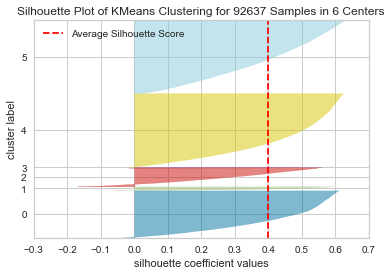

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 92637 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [37]:
from yellowbrick.cluster import SilhouetteVisualizer

n_clusters = 6
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X)
# The silhouette_score gives the average value for all the   samples.
# Calculating number of clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print("For n_clusters =", n_clusters, "The average   silhoutte_score is :", silhouette_avg)
# Using Silhouette Plot
visualizer = SilhouetteVisualizer(clusterer, colors='yellowbrick')
# Fit the data to the visualizer
visualizer.fit(X)
# Render the figure
visualizer.show()

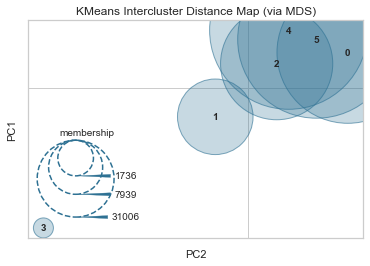

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=6, random_state=10))

In [38]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(6, random_state=10), data_pca)

In [39]:
clusters_stats

,Récence,Fréquence,Montant,Avis,Delivery_time
clusters,,,,,
0,440.433057,0.000000,132.621624,4.654291,11.588352
1,285.731278,0.001468,1200.684787,4.141948,13.500582
2,277.281787,0.000000,146.253257,1.845191,12.540599
3,287.290226,0.001199,168.084571,2.032980,38.891741
4,169.816113,0.000000,130.978335,4.717078,9.877046
5,311.683809,1.000000,78.338429,4.121489,12.798898


### Analyse des clusters :

0: Clients ayant acheté qu'une fois et il y a longtemps 

1: Clients ayant acheté pour une grosse somme, montant moyen à 1200

2: Clients mécontents à cause du produit (Avis faible mais temps de livraison faible)

3: Clients mécontents à cause de la livraison (Avis faible et temps de livraison élevée)

4: Clients ayant acheté qu'une fois mais récemment

5: Clients récurrents

### DBScan

In [40]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=15, min_samples=500).fit(X)
cluster = clustering.labels_

In [41]:
data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  46639
Nombre d'individus dans le cluster n° 0  :  45998
Nombre d'individus dans le cluster n° 1  :  0


In [42]:
clustering = DBSCAN(eps=10, min_samples=180).fit(X)
cluster = clustering.labels_

data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  46927
Nombre d'individus dans le cluster n° 0  :  43713
Nombre d'individus dans le cluster n° 1  :  1442
Nombre d'individus dans le cluster n° 2  :  441
Nombre d'individus dans le cluster n° 3  :  114
Nombre d'individus dans le cluster n° 4  :  0


In [43]:
clustering = DBSCAN(eps=30, min_samples=120).fit(X)
cluster = clustering.labels_

data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  5268
Nombre d'individus dans le cluster n° 0  :  87369
Nombre d'individus dans le cluster n° 1  :  0


In [44]:
clustering = DBSCAN(eps=30, min_samples=60).fit(X)
cluster = clustering.labels_

data_review["clusters"] = clustering.labels_
for i in range(-1, len(data_review['clusters'].unique())):
    print("Nombre d'individus dans le cluster n°", i, " : ", data_review['customer_unique_id'].loc[data_review['clusters'] == i].count())

Nombre d'individus dans le cluster n° -1  :  3288
Nombre d'individus dans le cluster n° 0  :  88904
Nombre d'individus dans le cluster n° 1  :  172
Nombre d'individus dans le cluster n° 2  :  153
Nombre d'individus dans le cluster n° 3  :  61
Nombre d'individus dans le cluster n° 4  :  59
Nombre d'individus dans le cluster n° 5  :  0


On peut voir ici que même en changeant les paramètres du modèle il est très difficile d'obtenir des clusters intéressants.
Nous allons donc rester sur notre modèle de K-means pour la suite.